In [1]:

# Use [NREL's FASTSim](https://github.com/NREL/fastsim) to find optimum battery and
# motor size subject to 0-60 mph constraint of 10 s and a fixed cost + linear cost per battery
# energy and motor/battery power of $25/kW-hr and $5/kW, respectively, using a 2022 Tesla Model 3
# RWD with the goal of minimizing 5 year operating cost 

# imports
from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

import fastsim as fsim
from fastsim import fsr

# build SimDriveLabel object for battery electric vehicle (BEV)
veh_base = fsim.vehicle.Vehicle.from_vehdb(22).to_rust()
assert veh_base.scenario_name == "2016 TESLA Model S60 2WD", "Loaded the wrong vehicle."

def get_vehicle_metrics(
    mc_max_kw: float,
    ess_max_kwh: float,
) -> Tuple[float, float]:
    """
    Simulates fastsim to calculate combined (mix of hwy and city) label mpg

    Args:
        mc_max_kw (float): motor max power [kW]


    Returns:
        Tuple[float, float]: combined label mpg and 0-60 mph time [s]
    """

    veh = veh_base.copy()
    fsim.utils.set_attr_with_path(
        veh,  # vehicle object
        "mc_max_kw",  # vehicle attribute to set
        mc_max_kw,  # new value
    )
    fsim.utils.set_attr_with_path(
        veh,  # vehicle object
        "ess_max_kw",  # vehicle attribute to set
        veh.mc_max_kw * 1.1,  # 10% higher than `veh.mc_max_kw`
    )
    fsim.utils.set_attr_with_path(
        veh,  # vehicle object
        "ess_max_kwh",  # vehicle attribute to set
        ess_max_kwh
    )
    veh.set_derived()
    sdl: fsr.LabelFe = fsr.get_label_fe(veh)[0]
    return sdl.adj_comb_kwh_per_mi, sdl.net_accel

# Constants for calculations
annual_mileage = 15e3
# energy cost per kwh
cost_per_grid_kwh = 0.12
cost_per_mc_kw = 5.0  # this number is based on engineering judgment
cost_per_ess_kwh = 250.0  # this number is based on engineering judgment


# Functions
def obj_fun(params: Tuple[float, float]) -> float:
    """
    Get 5 year cost of ownership (including component costs but not overall purchase cost)

    Args:
        params (Tuple[float, float]): (mc_max_kw, ess_max_kwh)

    Returns:
        float: 5-year operating cost
    """

    kwh_per_mi = get_vehicle_metrics(mc_max_kw, ess_max_kwh)[0]
    annual_kwh = annual_mileage / kwh_per_mi
    cost_5_years = cost_per_grid_kwh * annual_kwh + \
        cost_per_ess_kwh * ess_max_kwh + \
        cost_per_mc_kw * mc_max_kw

    return cost_5_years


# maximum allowable zero-to-sixty time [s]
max_zero_to_sixty = 6.0


def constraint_fun(
    params: Tuple[float, float]
) -> float:
    """
    Return positive for constraint violation.

    Args:
        params (Tuple[float, float]): (mc_max_kw, ess_max_kwh)

    Returns:
        float: positive value if constraint is violated
    """
    mc_max_kw, ess_max_kwh = params
    return max_zero_to_sixty - \
        get_vehicle_metrics(mc_max_kw, ess_max_kwh)[1]


## Via plotting

# create an array of possible motor peak power
mc_max_kw_arr = np.linspace(0.8, 1.5, 5) * veh_base.mc_max_kw
# create an array of possible motor peak power
ess_max_kwh_arr = np.linspace(0.8, 1.5, 20) * veh_base.ess_max_kwh
# Initialize arrays for storing results
adj_comb_kwh_per_mi_arr = []  # combined battery energy [kWh] per distance [mi]
zero_to_sixty_arr = []
cost_5_year_arr = []


# i is a loop counter and `fc_max_kw` is the value at the index for that iteration
for i, mc_max_kw in enumerate(mc_max_kw_arr):
    print(f"Solving for mc_max_kw: {mc_max_kw:.3g}")
    for j, ess_max_kwh in enumerate(ess_max_kwh_arr): 
        print(f"Solving for ess_max_kwh: {ess_max_kwh:.3g}")
        veh = veh_base.copy()
        fsim.utils.set_attr_with_path(
            veh,  # vehicle object
            "mc_max_kw",  # vehicle attribute to set
            mc_max_kw,  # new value
        )
        fsim.utils.set_attr_with_path(
            veh,  # vehicle object
            "ess_max_kw",  # vehicle attribute to set
            veh.mc_max_kw * 1.1,  # 10% higher than `veh.mc_max_kw`
        )
        fsim.utils.set_attr_with_path(
            veh,  # vehicle object
            "ess_max_kwh",  # vehicle attribute to set
            ess_max_kwh
        )
        veh.set_derived()
        sdl: fsr.LabelFe = fsr.get_label_fe(veh)[0]
        adj_comb_kwh_per_mi_arr.append(sdl.adj_comb_kwh_per_mi)
        zero_to_sixty_arr.append(sdl.net_accel)
        cost_5_year_arr.append(obj_fun((mc_max_kw, ess_max_kwh)))

adj_comb_kwh_per_mi_arr = np.reshape(
    adj_comb_kwh_per_mi_arr,
    (len(mc_max_kw_arr), len(ess_max_kwh_arr)))
zero_to_sixty_arr = np.reshape(
    zero_to_sixty_arr, (len(mc_max_kw_arr), len(ess_max_kwh_arr)))
cost_5_year_arr = np.reshape(
    cost_5_year_arr, (len(mc_max_kw_arr), len(ess_max_kwh_arr)))


No module named 'pymoo'
Try running `pip install pymoo==0.6.0.1` to use all features in `fastsim.calibration`
2024-03-11 15:23:30.747 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01514 exceeds tolerance of 0.00100
2024-03-11 15:23:30.747 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59579 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:30.754 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01514 exceeds tolerance of 0.00100
2024-03-11 15:23:30.755 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59579 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:30.762 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01519 exceeds tolerance of 0.00100
2024-03-11 15:23:30.762 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59572 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:30.769 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01519 exceeds tolerance of 0.00100
2024-03-11 15:23:30.769 

Solving for mc_max_kw: 228
Solving for ess_max_kwh: 60
Solving for ess_max_kwh: 62.8
Solving for ess_max_kwh: 65.5
Solving for ess_max_kwh: 68.3
Solving for ess_max_kwh: 71.1
Solving for ess_max_kwh: 73.8
Solving for ess_max_kwh: 76.6
Solving for ess_max_kwh: 79.3
Solving for ess_max_kwh: 82.1
Solving for ess_max_kwh: 84.9
Solving for ess_max_kwh: 87.6
Solving for ess_max_kwh: 90.4
Solving for ess_max_kwh: 93.2
Solving for ess_max_kwh: 95.9
Solving for ess_max_kwh: 98.7
Solving for ess_max_kwh: 101


2024-03-11 15:23:30.953 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01606 exceeds tolerance of 0.00100
2024-03-11 15:23:30.953 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59496 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:30.959 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01606 exceeds tolerance of 0.00100
2024-03-11 15:23:30.960 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59496 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:30.966 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01613 exceeds tolerance of 0.00100
2024-03-11 15:23:30.967 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59492 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:30.973 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01613 exceeds tolerance of 0.00100
2024-03-11 15:23:30.973 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59492 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 1

Solving for ess_max_kwh: 104
Solving for ess_max_kwh: 107
Solving for ess_max_kwh: 110
Solving for ess_max_kwh: 112
Solving for mc_max_kw: 278
Solving for ess_max_kwh: 60
Solving for ess_max_kwh: 62.8
Solving for ess_max_kwh: 65.5
Solving for ess_max_kwh: 68.3
Solving for ess_max_kwh: 71.1
Solving for ess_max_kwh: 73.8
Solving for ess_max_kwh: 76.6
Solving for ess_max_kwh: 79.3
Solving for ess_max_kwh: 82.1
Solving for ess_max_kwh: 84.9
Solving for ess_max_kwh: 87.6
Solving for ess_max_kwh: 90.4


2024-03-11 15:23:31.171 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01499 exceeds tolerance of 0.00100
2024-03-11 15:23:31.171 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59506 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:31.177 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01499 exceeds tolerance of 0.00100
2024-03-11 15:23:31.178 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59506 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:31.184 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01503 exceeds tolerance of 0.00100
2024-03-11 15:23:31.185 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59501 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:31.191 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01503 exceeds tolerance of 0.00100
2024-03-11 15:23:31.192 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59501 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 1

Solving for ess_max_kwh: 93.2
Solving for ess_max_kwh: 95.9
Solving for ess_max_kwh: 98.7
Solving for ess_max_kwh: 101
Solving for ess_max_kwh: 104
Solving for ess_max_kwh: 107
Solving for ess_max_kwh: 110
Solving for ess_max_kwh: 112
Solving for mc_max_kw: 328
Solving for ess_max_kwh: 60
Solving for ess_max_kwh: 62.8
Solving for ess_max_kwh: 65.5
Solving for ess_max_kwh: 68.3
Solving for ess_max_kwh: 71.1
Solving for ess_max_kwh: 73.8
Solving for ess_max_kwh: 76.6
Solving for ess_max_kwh: 79.3


2024-03-11 15:23:31.390 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01454 exceeds tolerance of 0.00100
2024-03-11 15:23:31.391 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59516 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:31.397 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01455 exceeds tolerance of 0.00100
2024-03-11 15:23:31.397 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59511 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:31.403 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01455 exceeds tolerance of 0.00100
2024-03-11 15:23:31.404 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59511 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:31.410 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01457 exceeds tolerance of 0.00100
2024-03-11 15:23:31.411 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59507 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 1

Solving for ess_max_kwh: 82.1
Solving for ess_max_kwh: 84.9
Solving for ess_max_kwh: 87.6
Solving for ess_max_kwh: 90.4
Solving for ess_max_kwh: 93.2
Solving for ess_max_kwh: 95.9
Solving for ess_max_kwh: 98.7
Solving for ess_max_kwh: 101
Solving for ess_max_kwh: 104
Solving for ess_max_kwh: 107
Solving for ess_max_kwh: 110
Solving for ess_max_kwh: 112
Solving for mc_max_kw: 378
Solving for ess_max_kwh: 60
Solving for ess_max_kwh: 62.8
Solving for ess_max_kwh: 65.5
Solving for ess_max_kwh: 68.3


2024-03-11 15:23:31.602 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01440 exceeds tolerance of 0.00100
2024-03-11 15:23:31.603 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59527 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:31.609 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01440 exceeds tolerance of 0.00100
2024-03-11 15:23:31.610 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59522 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:31.616 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01440 exceeds tolerance of 0.00100
2024-03-11 15:23:31.616 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59522 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:31.623 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01440 exceeds tolerance of 0.00100
2024-03-11 15:23:31.623 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59517 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 1

Solving for ess_max_kwh: 71.1
Solving for ess_max_kwh: 73.8
Solving for ess_max_kwh: 76.6
Solving for ess_max_kwh: 79.3
Solving for ess_max_kwh: 82.1
Solving for ess_max_kwh: 84.9
Solving for ess_max_kwh: 87.6
Solving for ess_max_kwh: 90.4
Solving for ess_max_kwh: 93.2
Solving for ess_max_kwh: 95.9
Solving for ess_max_kwh: 98.7
Solving for ess_max_kwh: 101
Solving for ess_max_kwh: 104
Solving for ess_max_kwh: 107
Solving for ess_max_kwh: 110
Solving for ess_max_kwh: 112


2024-03-11 15:23:31.814 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01452 exceeds tolerance of 0.00100
2024-03-11 15:23:31.814 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59457 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:31.821 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01452 exceeds tolerance of 0.00100
2024-03-11 15:23:31.822 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59457 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:31.828 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01439 exceeds tolerance of 0.00100
2024-03-11 15:23:31.829 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59533 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:31.836 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01439 exceeds tolerance of 0.00100
2024-03-11 15:23:31.836 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59533 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 1

Solving for mc_max_kw: 428
Solving for ess_max_kwh: 60
Solving for ess_max_kwh: 62.8
Solving for ess_max_kwh: 65.5
Solving for ess_max_kwh: 68.3
Solving for ess_max_kwh: 71.1
Solving for ess_max_kwh: 73.8
Solving for ess_max_kwh: 76.6
Solving for ess_max_kwh: 79.3
Solving for ess_max_kwh: 82.1
Solving for ess_max_kwh: 84.9
Solving for ess_max_kwh: 87.6
Solving for ess_max_kwh: 90.4
Solving for ess_max_kwh: 93.2
Solving for ess_max_kwh: 95.9
Solving for ess_max_kwh: 98.7


2024-03-11 15:23:32.029 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01436 exceeds tolerance of 0.00100
2024-03-11 15:23:32.029 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59469 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:32.035 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01437 exceeds tolerance of 0.00100
2024-03-11 15:23:32.036 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59465 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:32.042 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01437 exceeds tolerance of 0.00100
2024-03-11 15:23:32.043 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59465 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:32.049 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01437 exceeds tolerance of 0.00100
2024-03-11 15:23:32.050 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59462 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 1

Solving for ess_max_kwh: 101
Solving for ess_max_kwh: 104
Solving for ess_max_kwh: 107
Solving for ess_max_kwh: 110
Solving for ess_max_kwh: 112


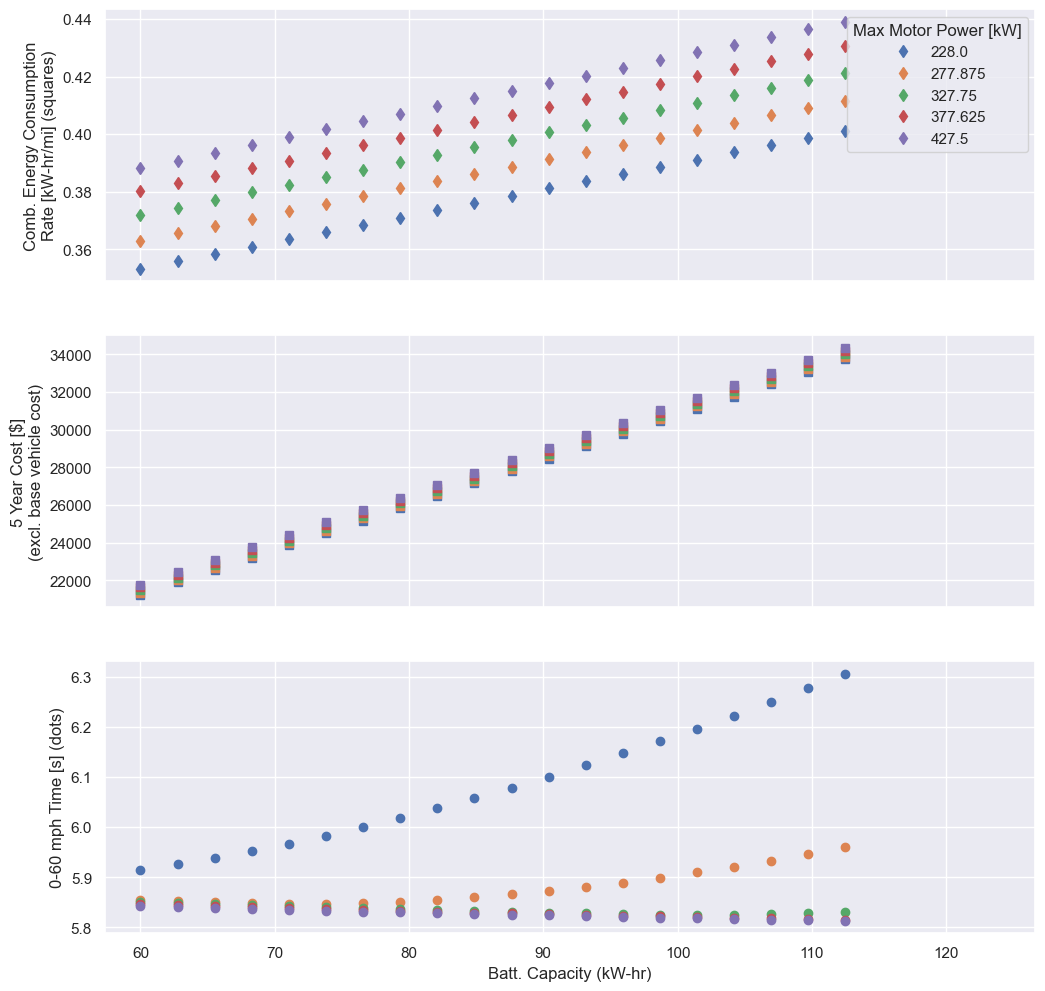

In [2]:

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(12, 12))
for i, mc_max_kw in enumerate(mc_max_kw_arr):
    ax0.plot(
        ess_max_kwh_arr,
        adj_comb_kwh_per_mi_arr[i, :],
        linestyle="",
        marker='d',
        label=mc_max_kw,
    )

    ax1.plot(
        ess_max_kwh_arr,
        cost_5_year_arr[i, :],
        linestyle="",
        marker='s',
    )

    ax2.plot(
        ess_max_kwh_arr,
        zero_to_sixty_arr[i, :],
        linestyle="",
        marker='o',
    )

ax2.set_ylabel("0-60 mph Time [s] (dots)")
ax2.set_xlabel('Batt. Capacity (kW-hr)')
ax1.set_ylabel("5 Year Cost [$]\n(excl. base vehicle cost)")
ax0.set_ylabel("Comb. Energy Consumption\nRate [kW-hr/mi] (squares)")
ax0.set_xlim((ax0.get_xlim()[0], ax0.get_xlim()[1] * 1.1))

ax0.legend(title="Max Motor Power [kW]")
plt.show()


In [3]:

constraints = {'type': 'eq', 'fun': constraint_fun}
bounds = [
    (mc_max_kw_arr.min(), mc_max_kw_arr.max()),
    (ess_max_kwh_arr.min(), ess_max_kwh_arr.max()),
]

min_res = minimize(
    obj_fun,
    (300, 100),  # initial guess
    bounds=bounds,
    constraints=constraints
)
opt_mc_max_kw, opt_ess_max_kwh = min_res.x

print('\n')
print("*"*25)
print("Conditions that minimize 5 year operating cost while")
print(f"keeping 0-60 mph time under {max_zero_to_sixty} s:")
print(f"optimized motor power [kW]: {opt_mc_max_kw}")
print(f"optimized battery capacity [kW-hr]: {opt_ess_max_kwh}")
print("Note that the results agree reasonably well with the plots.")

# Open-ended question: what are pros/cons of using plotting compared to scipy optimize?




2024-03-11 15:23:32.584 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01489 exceeds tolerance of 0.00100
2024-03-11 15:23:32.584 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59487 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:32.591 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01438 exceeds tolerance of 0.00100
2024-03-11 15:23:32.592 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59451 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:32.599 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01438 exceeds tolerance of 0.00100
2024-03-11 15:23:32.600 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59451 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 15:23:32.606 | simdrive_impl.rs:1870 | WARNING: trace miss distance fraction 0.01438 exceeds tolerance of 0.00100
2024-03-11 15:23:32.606 | simdrive_impl.rs:1888 | WARNING: trace miss speed 39.59451 m/s exceeds tolerance of 1.00000 m/s
2024-03-11 1



*************************
Conditions that minimize 5 year operating cost while
keeping 0-60 mph time under 6.0 s:
optimized motor power [kW]: 264.8942551364914
optimized battery capacity [kW-hr]: 108.69805070143718
Note that the results agree reasonably well with the plots.
